<a href="https://colab.research.google.com/github/Vtewari2311/Color_Summarizer_Sensory_Research/blob/main/Color_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from PIL import Image, ImageDraw, ImageOps
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import colormap as cm
import webcolors 
webcolors.CSS3_HEX_TO_NAMES
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Markdown, display, HTML
%matplotlib inline

##User Defined Functions

In [84]:
# Taken directly from: 
    # https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

# Function taken from: 
    # https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python/9694246#9694246
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Equations taken from Wikipedia Page: 
    # https://en.wikipedia.org/wiki/HSL_and_HSV#General_approach
def rgb_2_hsv(rgb_list):
    r = rgb_list[0]/255
    g = rgb_list[1]/255
    b = rgb_list[2]/255
    
    minRGB = min(r,g,b)
    maxRGB = max(r,g,b)
    RGBrange = maxRGB-minRGB

    # Black/White/Any Shade of Grey
    if (minRGB == maxRGB):
        Value = minRGB
        return [0,0,Value]
    else:
        Saturation = RGBrange/maxRGB
        Value = maxRGB

        if (maxRGB == r): Hue = ((g-b)/RGBrange) % 6
        elif (maxRGB == g): Hue = ((b-r)/RGBrange) + 2
        elif (maxRGB == b): Hue = ((r-g)/RGBrange) + 4

        return [Hue*60, Saturation, Value]

# Three in one wrapper function
def modified_rgb2hex(RGB):
    hexs.append(cm.rgb2hex(int(RGB[0]), int(RGB[1]), int(RGB[2])))
    names.append(get_colour_name((int(RGB[0]), int(RGB[1]), int(RGB[2])))[1])
    hsv.append(rgb_2_hsv([int(RGB[0]), int(RGB[1]), int(RGB[2])]))
    
def add_border(image, color):
    return ImageOps.expand(image,border=10,fill=color)

def image_color_summary(im):
    printmd("# Image Color Cluster Summarizer")
    print("\n")
    printmd("### The image used in this notebook")
    display(im)
    print("\n")
    printmd("## Color Clusters")
    printmd("The Color Cluster Summarizer will produce descriptive statistics about the color spectrum of an image. After loading an image, the summarizer will split the pixels into 5 distinct channels, based on their RGB colors.")
    printmd("The average color of each cluster will be reported via its Common Color Name, Hex code, RGB value, and HSV value.")
    printmd("The summarizer also reports the breakdown of colors within each cluster, based on the nearest Common Color Name from a pixel's RGB value")
    #printmd("### The Image in Words")
    #printmd(all_words)
    display(fig7)
    display(HTML(htmltable))
    printmd("### Image Cluster Partitions")
    printmd("Each pixel in the image is assigned to one of five groups based on the RGB value. These are called the Cluster Partitions. For each cluster partition, we turn hide the pixels of other partitions and reconstruct the image using only the pixel of the specific partition.")
    printmd("The border around each cluster partition represents the average color of the partition. This is calculated as the average RGB values of the partition.")
    plot_figures(partitions, nrows=1, ncols=len(clusters))
    
def printmd(string):
    display(Markdown(string))

#Image Cluster Summary

## Loading an Image

In [85]:
im = Image.open('ColoredPDF.jpg')
im_a = np.array(im)
width, height = im.size
if (im_a.shape[2] == 4):
    im_mode = "RGBA"
else:
    im_mode = "RGB"
    
pixel_values = list(im.getdata())

## K-Means Clustering

In [86]:
_pixel_values = list(im.getdata())

    # K Means Clustering
clusters = range(0,5)
test_K = KMeans(n_clusters=len(clusters), random_state=0).fit(pixel_values)
labels = test_K.labels_

    # Extract the Cluster Centers Info and Initialize the Final DF
Kmeans_df = test_K.cluster_centers_
Kmeans_df = [[int(x) for x in colors] for colors in Kmeans_df]
Kmeans_df = pd.DataFrame(Kmeans_df, columns=("R", "G", "B"))
Kmeans_df['RGB'] = Kmeans_df.iloc[:,0:3].values.tolist()
Kmeans_df.drop(Kmeans_df.columns[0:3], axis=1, inplace=True)

    # Obtain the cluster color names and color values in other color spaces
hexs = []
names = []
hsv = []
list(map(modified_rgb2hex, Kmeans_df['RGB']))

make_percent = lambda x: x*100
for v in hsv:
    v[0] = int(v[0])
    v[1] = round((make_percent(v[1])),1)
    v[2] = round((make_percent(v[2])),1)

Kmeans_df['Hex'] = hexs
Kmeans_df['Color Name'] = names
Kmeans_df['HSV'] = hsv

    # Get the color tags (all color names in each cluster)
tags = list(map(lambda x: get_colour_name(((int(x[0]), int(x[1]), int(x[2])))), pixel_values))
tags = [colors[1] for colors in tags]

color_tags = pd.DataFrame(pixel_values, columns=("R","G","B"))
color_tags['Cluster Number'] = labels
color_tags['Tags'] = tags
Kmeans_df['Tags'] = color_tags.groupby(by=['Cluster Number']).apply(lambda x: x['Tags'].unique())
Kmeans_df

    # Cluster Percentages
Kmeans_df['Percent'] = np.unique(labels, return_counts=True)[1]
Kmeans_df['Percent'] = round((Kmeans_df['Percent']/Kmeans_df['Percent'].sum())*100, 2)
Kmeans_df.sort_values('Percent', ascending=False, axis=0, inplace=True)
Kmeans_df['Percent'] = [str(x) + "%" for x in Kmeans_df['Percent']]
Kmeans_df = Kmeans_df[['Percent','Color Name', 'Hex', 'RGB', 'HSV', 'Tags']]
Kmeans_df.reset_index(drop=True, inplace=True)

    # The Image in Words
all_words = np.concatenate(Kmeans_df['Tags'])
all_words = np.unique(all_words)
all_words = ' '.join(str(x) for x in all_words)

## Clustering ColorBar (By Pixels)

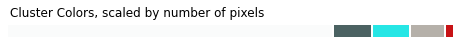

In [87]:
positions = list(Kmeans_df['Percent'].copy(deep=True))
positions = [x[:-1] for x in positions]
positions = pd.DataFrame(positions, columns=["Percent"]).apply(pd.to_numeric)
positions['Percent'] = positions['Percent']/100
positions['End'] = positions['Percent'].cumsum(axis=0)
positions['Start'] =  positions['End']-positions['Percent']


fig7 = plt.figure(figsize=(8,0.5))
fig7.suptitle("Cluster Colors, scaled by number of pixels", x=0.35)
ax7 = fig7.add_subplot(111)
for p in [
    patches.Rectangle(
        (positions['Start'][0], 0), positions['Percent'][0], 1, facecolor=Kmeans_df['Hex'][0],
        edgecolor="#FFFFFF", linewidth=2
    ),
    patches.Rectangle(
        (positions['Start'][1], 0), positions['Percent'][1], 1, facecolor=Kmeans_df['Hex'][1],
        edgecolor="#FFFFFF", linewidth=2
    ),
    patches.Rectangle(
        (positions['Start'][2], 0), positions['Percent'][2], 1, facecolor=Kmeans_df['Hex'][2],
        edgecolor="#FFFFFF", linewidth=2
    ),
    patches.Rectangle(
        (positions['Start'][3], 0), positions['Percent'][3], 1, facecolor=Kmeans_df['Hex'][3],
        edgecolor="#FFFFFF", linewidth=2
    ),
    patches.Rectangle(
        (positions['Start'][4], 0), positions['Percent'][4], 1, facecolor=Kmeans_df['Hex'][4],
        edgecolor="#FFFFFF", linewidth=2
    )
]:
    ax7.add_patch(p)
    ax7.set_axis_off()
    plt.subplots_adjust(top=0.5)

## Create Image Cluster Partitions

In [88]:
# Create the Image Cluster Partitions 

    # Reorder clusters from largest to smallest
cluster_df = pd.DataFrame(np.unique(labels, return_counts=True)[0], columns=["Initial"])
cluster_df['Counts'] = np.unique(labels, return_counts=True)[1]
cluster_df.sort_values('Counts', ascending=False, axis=0, inplace=True)
cluster_df['New'] = list(clusters)
newclusters = dict(zip(cluster_df.Initial, cluster_df.New))

def mp(entry):
    return newclusters.get(entry, entry)
mp = np.vectorize(mp)

labels = mp(labels)
labels2 = labels.reshape(height,width)

partitions = {}

for i in clusters:
    img = Image.new(im_mode, (width, height), "white") 
    img_a = np.array(img)
    
    C0 = np.where(labels2 == i)
    rows = list(C0[0])
    cols = list(C0[1])

    for x in range(len(rows)):
            img_a[rows[x]][cols[x]] = im_a[rows[x]][cols[x]]

    img_new = Image.fromarray(img_a, mode=im_mode)
    img_new = add_border(img_new, Kmeans_df['Hex'][i])
    title_string = "Partition " +  str(i+1)
    partitions[title_string] = img_new


## Creating the cluster color sample image

## Display Table

In [91]:
htmltable = """<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;border-color:#ccc;margin:0px auto;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:3px 10px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#fff;border-top-width:1px;border-bottom-width:1px;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:3px 10px;border-style:solid;border-width:0px;overflow:hidden;word-break:normal;border-color:#ccc;color:#333;background-color:#f0f0f0;border-top-width:1px;border-bottom-width:1px;}
.tg .tg-g5xs{font-size:11px;text-align:center;vertical-align:top}
.tg .tg-r8vz{font-weight:bold;font-size:11px;vertical-align:top}
.tg .tg-b56p{font-weight:bold;font-size:11px;text-align:center;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
.tg .tg-q19q{font-size:11px;vertical-align:top}
.tg .tg-25al{font-size:10px;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 897px">
<colgroup>
<col style="width: 60px">
<col style="width: 60px">
<col style="width: 95px">
<col style="width: 70px">
<col style="width: 100px">
<col style="width: 100px">
<col style="width: 450px">
</colgroup>
    <tr>
        <th class="tg-r8vz">Cluster</th>
        <th class="tg-b56p">Pixels</th>
        <th class="tg-b56p">Color Name</th>
        <th class="tg-b56p">Hex</th>
        <th class="tg-b56p">RGB</th>
        <th class="tg-b56p">HSV</th>
        <th class="tg-b56p">tags</th>
    </tr>
    <tr>
        <td class="tg-yw4l"><img src="Figures/Cluster 1.jpg" style="width:20px;height:20px;"></td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Percent'][0]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Color Name'][0]) + """</td>
        <td class="tg-q19q">""" + str(Kmeans_df['Hex'][0]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['RGB'][0][0]) + " " +  str(Kmeans_df['RGB'][0][1]) + " " +  str(Kmeans_df['RGB'][0][2]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['HSV'][0][0]) + " " +  str(Kmeans_df['HSV'][0][1]) + " " +  str(Kmeans_df['HSV'][0][2]) + """</td>
        <td class="tg-25al">""" + str(Kmeans_df['Tags'][0]) + """</td>
    </tr>
    <tr>
        <td class="tg-yw4l"><img src="Figures/Cluster 2.jpg" style="width:20px;height:20px;"></td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Percent'][1]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Color Name'][1]) + """</td>
        <td class="tg-q19q">""" + str(Kmeans_df['Hex'][1]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['RGB'][1][0]) + " " +  str(Kmeans_df['RGB'][1][1]) + " " +  str(Kmeans_df['RGB'][1][2]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['HSV'][1][0]) + " " +  str(Kmeans_df['HSV'][1][1]) + " " +  str(Kmeans_df['HSV'][1][2]) + """</td>
        <td class="tg-25al">""" + str(Kmeans_df['Tags'][1]) + """</td>
    </tr>
    <tr>
        <td class="tg-yw4l"><img src="Figures/Cluster 3.jpg" style="width:20px;height:20px;"></td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Percent'][2]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Color Name'][2]) + """</td>
        <td class="tg-q19q">""" + str(Kmeans_df['Hex'][2]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['RGB'][2][0]) + " " +  str(Kmeans_df['RGB'][2][1]) + " " +  str(Kmeans_df['RGB'][2][2]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['HSV'][2][0]) + " " +  str(Kmeans_df['HSV'][2][1]) + " " +  str(Kmeans_df['HSV'][2][2]) + """</td>
        <td class="tg-25al">""" + str(Kmeans_df['Tags'][2]) + """</td>
    </tr>
    <tr>
        <td class="tg-yw4l"><img src="Figures/Cluster 4.jpg" style="width:20px;height:20px;"></td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Percent'][3]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Color Name'][3]) + """</td>
        <td class="tg-q19q">""" + str(Kmeans_df['Hex'][3]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['RGB'][3][0]) + " " +  str(Kmeans_df['RGB'][3][1]) + " " +  str(Kmeans_df['RGB'][3][2]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['HSV'][3][0]) + " " +  str(Kmeans_df['HSV'][3][1]) + " " +  str(Kmeans_df['HSV'][3][2]) + """</td>
        <td class="tg-25al">""" + str(Kmeans_df['Tags'][3]) + """</td>
    </tr>
    <tr>
        <td class="tg-yw4l"><img src="Figures/Cluster 5.jpg" style="width:20px;height:20px;"></td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Percent'][4]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['Color Name'][4]) + """</td>
        <td class="tg-q19q">""" + str(Kmeans_df['Hex'][4]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['RGB'][4][0]) + " " +  str(Kmeans_df['RGB'][4][1]) + " " +  str(Kmeans_df['RGB'][4][2]) + """</td>
        <td class="tg-g5xs">""" + str(Kmeans_df['HSV'][4][0]) + " " +  str(Kmeans_df['HSV'][4][1]) + " " +  str(Kmeans_df['HSV'][4][2]) + """</td>
        <td class="tg-25al">""" + str(Kmeans_df['Tags'][4]) + """</td>
    </tr>
</table>"""

# Image Color Cluster Summarizer

### The image used in this notebook

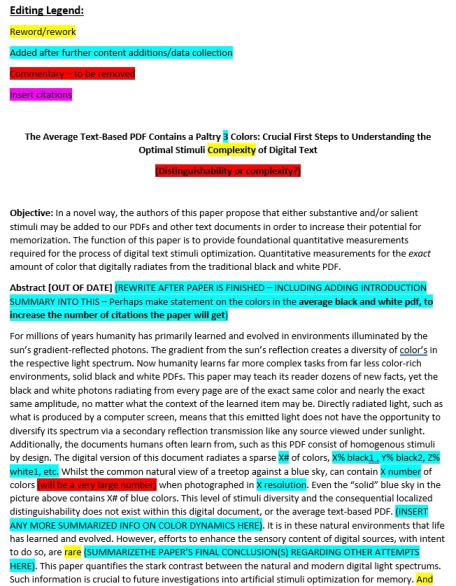

## Color Clusters

The Color Cluster Summarizer will produce descriptive statistics about the color spectrum of an image. After loading an image, the summarizer will split the pixels into 5 distinct channels, based on their RGB colors.

The average color of each cluster will be reported via its Common Color Name, Hex code, RGB value, and HSV value.

The summarizer also reports the breakdown of colors within each cluster, based on the nearest Common Color Name from a pixel's RGB value

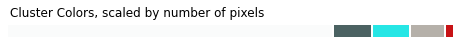

Cluster,Pixels,Color Name,Hex,RGB,HSV,tags
,73.02%,snow,#FAFBFB,250 251 251,180 0.4 98.4,['white' 'whitesmoke' 'snow' 'gainsboro' 'lavender' 'lightgray' 'linen' 'ivory' 'beige' 'mintcream' 'ghostwhite' 'floralwhite' 'lightyellow' 'lemonchiffon' 'moccasin' 'palegoldenrod' 'lightgoldenrodyellow' 'papayawhip' 'oldlace' 'khaki' 'cornsilk' 'honeydew' 'lavenderblush' 'blanchedalmond' 'azure' 'lightcyan' 'aliceblue' 'seashell' 'paleturquoise' 'powderblue' 'mistyrose' 'antiquewhite' 'pink' 'peachpuff' 'bisque' 'plum' 'violet' 'thistle']
,8.77%,dimgray,#4B6262,75 98 98,180 23.5 38.4,['dimgray' 'darkslategray' 'black' 'gray' 'darkgoldenrod' 'olive' 'darkolivegreen' 'yellowgreen' 'olivedrab' 'saddlebrown' 'teal' 'darkcyan' 'steelblue' 'lightseagreen' 'cadetblue' 'seagreen' 'mediumseagreen' 'maroon' 'darkmagenta' 'darkviolet' 'purple' 'darkorchid' 'mediumvioletred' 'darkslateblue' 'slategray' 'darkgreen' 'peru' 'indianred' 'sienna' 'brown' 'midnightblue' 'lightslategray' 'goldenrod']
,8.53%,turquoise,#26E6E5,38 230 229,179 83.5 90.2,['skyblue' 'turquoise' 'mediumturquoise' 'cyan' 'deepskyblue' 'darkturquoise' 'lightseagreen' 'lightskyblue' 'mediumaquamarine' 'aquamarine' 'darkcyan' 'cadetblue' 'cornflowerblue' 'steelblue' 'paleturquoise']
,7.78%,darkgray,#B5B0A9,181 176 169,34 6.6 71.0,['darkgray' 'silver' 'gray' 'lightgray' 'lightslategray' 'khaki' 'greenyellow' 'yellow' 'gold' 'yellowgreen' 'darkkhaki' 'goldenrod' 'sandybrown' 'burlywood' 'palegoldenrod' 'skyblue' 'paleturquoise' 'mediumaquamarine' 'cadetblue' 'lightpink' 'peachpuff' 'wheat' 'pink' 'mediumorchid' 'magenta' 'orchid' 'darkorchid' 'darkviolet' 'mediumvioletred' 'deeppink' 'violet' 'aquamarine' 'darkseagreen' 'thistle' 'palegreen' 'lightgreen' 'tan' 'rosybrown' 'indianred' 'powderblue' 'lightsteelblue' 'lightblue' 'steelblue' 'lightskyblue' 'cornflowerblue' 'tomato' 'palevioletred']
,1.9%,firebrick,#C71215,199 18 21,359 91.0 78.0,['darkgoldenrod' 'indianred' 'crimson' 'brown' 'firebrick' 'sienna' 'red' 'darkred' 'maroon' 'tomato' 'orangered' 'chocolate' 'darkviolet' 'darkmagenta' 'mediumvioletred' 'saddlebrown']


### Image Cluster Partitions

Each pixel in the image is assigned to one of five groups based on the RGB value. These are called the Cluster Partitions. For each cluster partition, we turn hide the pixels of other partitions and reconstruct the image using only the pixel of the specific partition.

The border around each cluster partition represents the average color of the partition. This is calculated as the average RGB values of the partition.

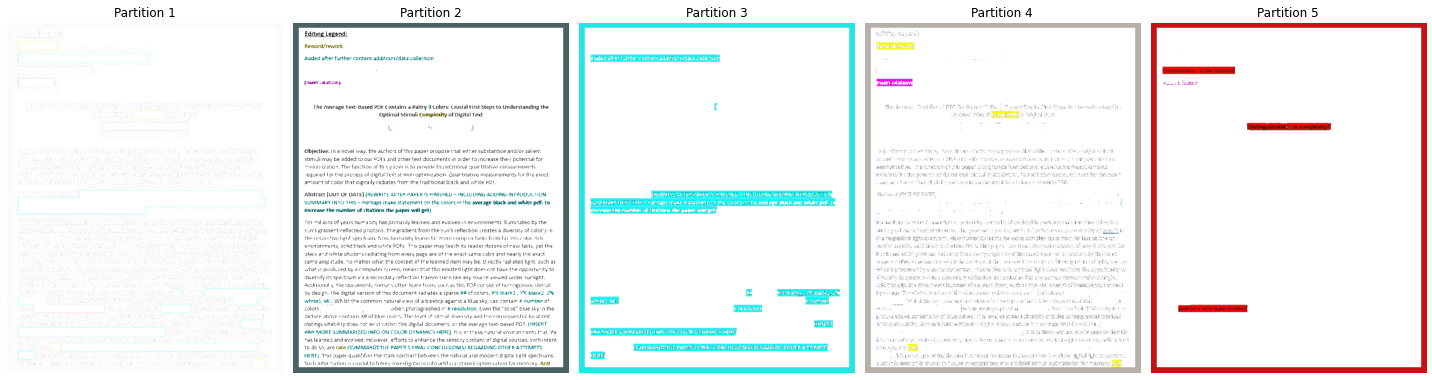

In [93]:
image_color_summary(im)